In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content


In [ ]:
!ls

drive  sample_data


In [ ]:
pwd


'/content'

In [ ]:
!pip install -q keras

In [ ]:
import keras
data_path = '/content/drive/My Drive/Colab Notebooks/data/Zisf2020_SOLARFARM1_15MIN_201001_201804_lag_96_addition_version2.csv'

In [ ]:
import pandas as pd
# df = pd.read_csv(data_path, index_col='dattim')
df = pd.read_csv(data_path)
df.head(1)

,Unnamed: 0,dattim,avepow,avepow_t-1,avepow_t-2,avepow_t-3,avepow_t-4,avepow_t-5,avepow_t-6,avepow_t-7,avepow_t-8,avepow_t-9,avepow_t-10,avepow_t-11,avepow_t-12,avepow_t-13,avepow_t-14,avepow_t-15,avepow_t-16,avepow_t-17,avepow_t-18,avepow_t-19,avepow_t-20,avepow_t-21,avepow_t-22,avepow_t-23,avepow_t-24,avepow_t-25,avepow_t-26,avepow_t-27,avepow_t-28,avepow_t-29,avepow_t-30,avepow_t-31,avepow_t-32,avepow_t-33,avepow_t-34,avepow_t-35,avepow_t-36,avepow_t-37,...,avepow_t-60,avepow_t-61,avepow_t-62,avepow_t-63,avepow_t-64,avepow_t-65,avepow_t-66,avepow_t-67,avepow_t-68,avepow_t-69,avepow_t-70,avepow_t-71,avepow_t-72,avepow_t-73,avepow_t-74,avepow_t-75,avepow_t-76,avepow_t-77,avepow_t-78,avepow_t-79,avepow_t-80,avepow_t-81,avepow_t-82,avepow_t-83,avepow_t-84,avepow_t-85,avepow_t-86,avepow_t-87,avepow_t-88,avepow_t-89,avepow_t-90,avepow_t-91,avepow_t-92,avepow_t-93,avepow_t-94,avepow_t-95,avepow_t-96,avetem,avegloirr,avewinspe
0,0,1/2/2010 0:15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,2.17,23.85,98.61,110.07,169.02,22.48,361.11,302.8,358.23,57.0,...,23.45,31.19,20.71,16.14,18.04,13.37,1.65,0.14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.78,0.2,7.85


In [ ]:
df.tail(1)

,Unnamed: 0,dattim,avepow,avepow_t-1,avepow_t-2,avepow_t-3,avepow_t-4,avepow_t-5,avepow_t-6,avepow_t-7,avepow_t-8,avepow_t-9,avepow_t-10,avepow_t-11,avepow_t-12,avepow_t-13,avepow_t-14,avepow_t-15,avepow_t-16,avepow_t-17,avepow_t-18,avepow_t-19,avepow_t-20,avepow_t-21,avepow_t-22,avepow_t-23,avepow_t-24,avepow_t-25,avepow_t-26,avepow_t-27,avepow_t-28,avepow_t-29,avepow_t-30,avepow_t-31,avepow_t-32,avepow_t-33,avepow_t-34,avepow_t-35,avepow_t-36,avepow_t-37,...,avepow_t-60,avepow_t-61,avepow_t-62,avepow_t-63,avepow_t-64,avepow_t-65,avepow_t-66,avepow_t-67,avepow_t-68,avepow_t-69,avepow_t-70,avepow_t-71,avepow_t-72,avepow_t-73,avepow_t-74,avepow_t-75,avepow_t-76,avepow_t-77,avepow_t-78,avepow_t-79,avepow_t-80,avepow_t-81,avepow_t-82,avepow_t-83,avepow_t-84,avepow_t-85,avepow_t-86,avepow_t-87,avepow_t-88,avepow_t-89,avepow_t-90,avepow_t-91,avepow_t-92,avepow_t-93,avepow_t-94,avepow_t-95,avepow_t-96,avetem,avegloirr,avewinspe
265629,265629,5/1/2018 0:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.29,3.46,32.79,119.76,232.74,371.59,508.42,587.46,632.92,676.14,706.87,733.98,754.72,768.8,784.99,796.73,796.3,795.67,794.12,...,805.43,795.73,777.14,759.56,734.3,701.59,666.48,614.42,469.5,310.34,156.15,53.55,12.1,3.11,0.68,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57.72,0.0,1.45


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.3.0


In [ ]:
import csv
time_step = []
solar = []

with open( data_path) as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    solar.append(float(row[2]))
    time_step.append(int(row[0]))

In [ ]:
import numpy as np
series = np.array(solar)
time = np.array(time_step)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)

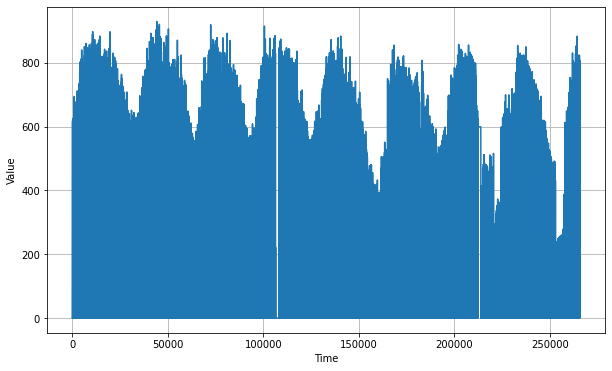

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [ ]:
split_time = 254108
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:split_time + 672]
x_valid = series[split_time:split_time + 672]

window_size = 672
batch_size = 100
shuffle_buffer_size = 1000

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 672
batch_size = 100
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae", "mape", "accuracy"])
history = model.fit(train_set, epochs=57, callbacks=[lr_schedule])

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(254108,)
Epoch 1/57
2535/2535 [==============================] - 152s 60ms/step - loss: 144.5822 - mae: 145.0724 - mape: 3609336064.0000 - accuracy: 0.1706
Epoch 2/57
2535/2535 [==============================] - 153s 60ms/step - loss: 118.5240 - mae: 119.0001 - mape: 2662240768.0000 - accuracy: 0.2061
Epoch 3/57
2535/2535 [==============================] - 157s 62ms/step - loss: 100.4919 - mae: 100.9517 - mape: 2349427456.0000 - accuracy: 0.2528
Epoch 4/57
2535/2535 [==============================] - 154s 61ms/step - loss: 83.4021 - mae: 83.8615 - mape: 2497822464.0000 - accuracy: 0.2626
Epoch 5/57
2535/2535 [==============================] - 154s 61ms/step - loss: 70.4315 - mae: 70.8860 - mape: 2583688960.0000 - accuracy: 0.2775
Epoch 6/57
2535/2535 [==============================] - 150s 59ms/step - loss: 61.1503 - mae: 61.5973 - mape: 2516100608.0000 - accuracy: 0.2988
Epoch 7/57
2535/2535

(1e-08, 0.0001, 0.0, 60.0)

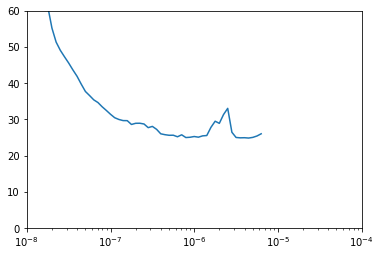

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
# rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]
rnn_forecast.shape

(264959, 672, 1)

In [ ]:
rnn_forecastx = rnn_forecast[split_time - window_size:split_time, -1, 0]

In [ ]:
rnn_forecastx.shape

(672,)

In [ ]:
split_time

254108

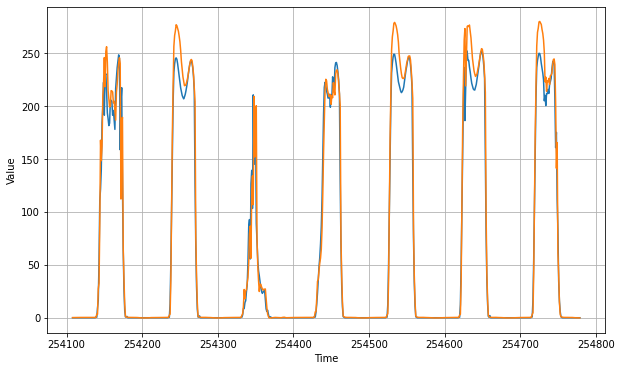

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecastx)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecastx).numpy()

6.8076754

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=672, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae", "mape", "accuracy"])
history = model.fit(train_set,epochs=25)

Epoch 1/25
2535/2535 [==============================] - 153s 60ms/step - loss: 40.0536 - mae: 40.4701 - mape: 863050560.0000 - accuracy: 0.3472
Epoch 2/25
2535/2535 [==============================] - 150s 59ms/step - loss: 31.2635 - mae: 31.6647 - mape: 530834720.0000 - accuracy: 0.3736
Epoch 3/25
2535/2535 [==============================] - 153s 60ms/step - loss: 31.5567 - mae: 31.9570 - mape: 428646688.0000 - accuracy: 0.3826
Epoch 4/25
2535/2535 [==============================] - 151s 60ms/step - loss: 29.7083 - mae: 30.1109 - mape: 437318880.0000 - accuracy: 0.3717
Epoch 5/25
2535/2535 [==============================] - 153s 61ms/step - loss: 29.6126 - mae: 30.0138 - mape: 377373856.0000 - accuracy: 0.3734
Epoch 6/25
2535/2535 [==============================] - 151s 60ms/step - loss: 29.9957 - mae: 30.3862 - mape: 324012032.0000 - accuracy: 0.3892
Epoch 7/25
2535/2535 [==============================] - 154s 61ms/step - loss: 29.4990 - mae: 29.8882 - mape: 336319520.0000 - accuracy:

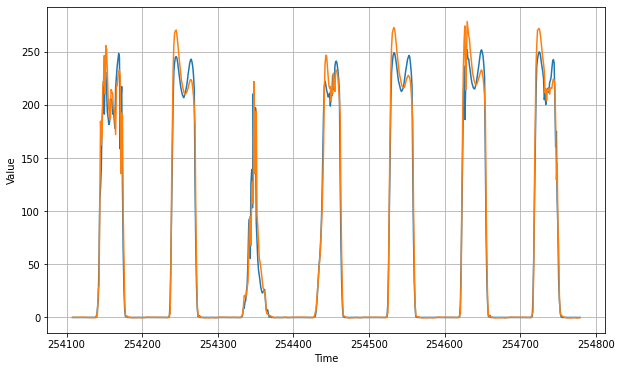

In [ ]:
rnn_forecast2 = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecastx2 = rnn_forecast2[split_time - window_size:split_time, -1, 0]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecastx2)


In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecastx2).numpy()

7.0009184